# 1. Particpante do Grupo
1. Leandro de Almeida Pina

# 2. Problema de Negócio
- O problema é de classificação multirrótulo: dada uma frase, o objetivo é classificá-la em várias categorias de discurso de ódio (Sexismo, Homofobia, Racismo, etc.).

# Carregar o Conjunto de Dados


In [15]:
import pandas as pd

# Carregar o conjunto de dados
df_balanced = pd.read_csv('balanced_hate_data.csv')


# 3. Base de Dados

In [16]:
# Tamanho da amostra
sample_size = df_balanced.shape[0]

# Colunas disponíveis
columns_available = df_balanced.columns.tolist()

print(f"Tamanho da amostra: {sample_size}")
print(f"Colunas disponíveis: {columns_available}")


Tamanho da amostra: 1045
Colunas disponíveis: ['text', 'Sexism', 'Women', 'Homophobia', 'Homossexuals', 'Lesbians', 'Body', 'Fat.people', 'Fat.women', 'Ugly.people', 'Ugly.women', 'Racism']


# 4. Análise Exploratória

# Visualizar a Distribuição das Etiquetas (Classes)


/home/marcelo/anaconda3/envs/transformers/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/marcelo/anaconda3/envs/transformers/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/marcelo/anaconda3/envs/transformers/lib/python3.9/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/marcelo/anaconda3/envs/transformers/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be rem

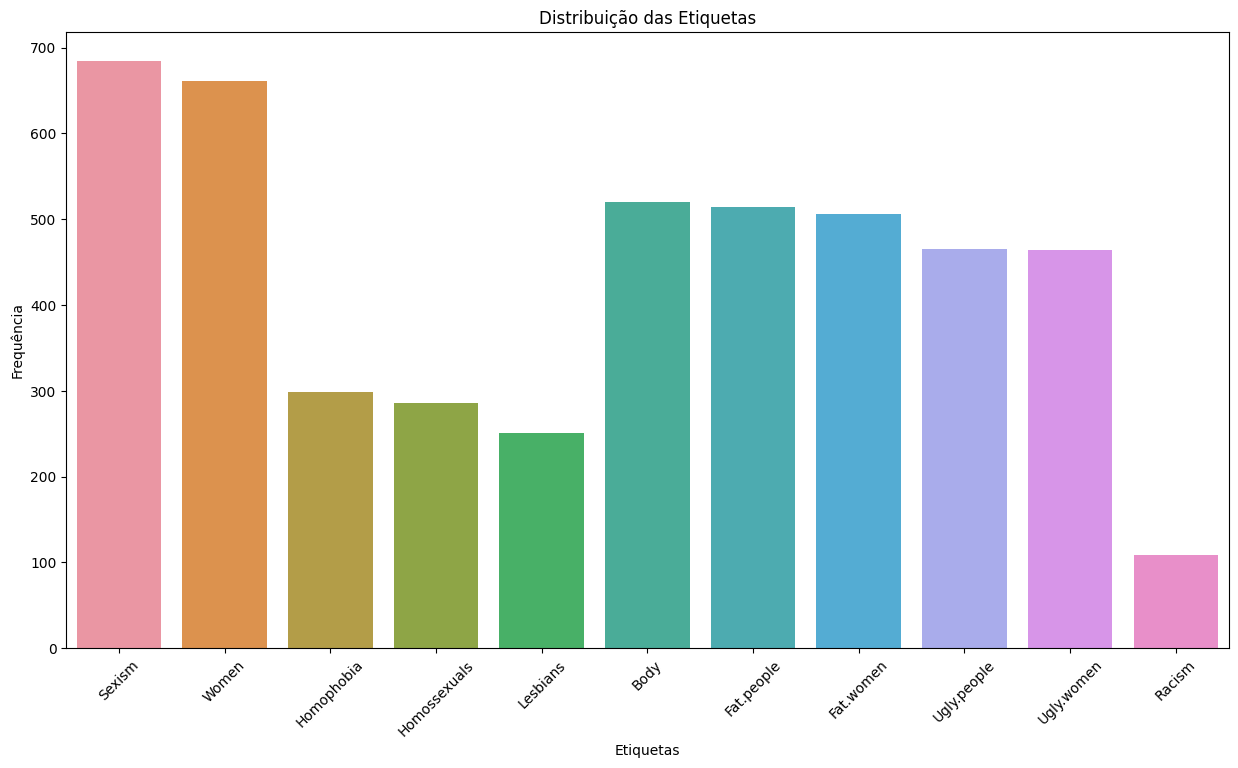

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Colunas corretas para as etiquetas
correct_labels_columns = ['Sexism', 'Women', 'Homophobia', 'Homossexuals', 'Lesbians', 'Body', 'Fat.people', 'Fat.women', 'Ugly.people', 'Ugly.women', 'Racism']

# Visualizar a distribuição das várias etiquetas
plt.figure(figsize=(15, 8))
sns.barplot(x=correct_labels_columns, y=df_balanced[correct_labels_columns].sum().values)
plt.title("Distribuição das Etiquetas")
plt.xlabel("Etiquetas")
plt.ylabel("Frequência")
plt.xticks(rotation=45)
plt.show()


# Visualizar a Distribuição do Comprimento dos Textos


/home/marcelo/anaconda3/envs/transformers/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/marcelo/anaconda3/envs/transformers/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


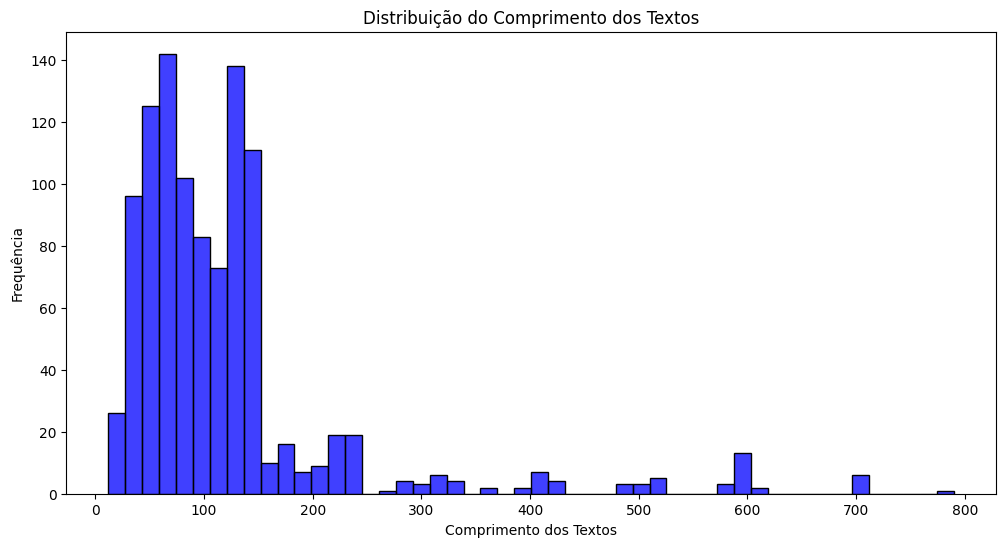

In [18]:
# Calcular o comprimento dos textos
df_balanced['text_length'] = df_balanced['text'].apply(len)

# Visualizar a distribuição do comprimento dos textos
plt.figure(figsize=(12, 6))
sns.histplot(df_balanced['text_length'], bins=50, kde=False, color='blue')
plt.title("Distribuição do Comprimento dos Textos")
plt.xlabel("Comprimento dos Textos")
plt.ylabel("Frequência")
plt.show()


# 5. Treinamento

#### Topologia dos Modelos

*   **Primeiro Modelo (Simples LSTM)**: Este é o modelo mais simples, projetado para servir como um ponto de partida ou linha de base. Ele contém apenas uma camada LSTM após a camada de incorporação. O objetivo era avaliar o desempenho do LSTM sem adicionar complexidade ao modelo.
    
*   **Segundo Modelo (LSTM + Dense Layer)**: Este modelo é uma extensão do primeiro, incluindo uma camada densa adicional para adicionar um pouco de complexidade. A adição dessa camada permite ao modelo aprender representações mais complexas dos dados, mas também aumenta o risco de overfitting.
    
*   **Terceiro Modelo (LSTM + Multiple Dense Layers)**: Este é o modelo mais complexo. Além da camada LSTM, ele inclui duas camadas densas adicionais. Esse design foi escolhido para capturar as representações mais complexas possíveis dos dados e fornecer o maior poder de generalização.
    

#### Seleção de Hiperparâmetros

*   Tamanho do lote (`batch_size`): 8. Escolhido para proporcionar um equilíbrio entre o uso eficiente da memória e a atualização mais frequente dos pesos do modelo.
*   Número máximo de palavras (`max_words`): 500. Limitado a 500 para manter apenas as palavras mais frequentes e tornar o modelo mais gerenciável.
*   Comprimento máximo da sequência (`max_sequence_length`): 50. Escolhido com base na distribuição do comprimento dos textos.

O treinamento para todos os modelos foi realizado com um conjunto de validação separado e pesos de classe para lidar com o desequilíbrio de classe. Os modelos foram treinados por 20 épocas.

In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#parametros 
batch_size = 8
# Tokenização e pad sequence
max_words = 500
max_sequence_length = 50

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(df_balanced['text'])
sequences = tokenizer.texts_to_sequences(df_balanced['text'])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Divisão dos dados
X = padded_sequences
y = df_balanced[correct_labels_columns].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# equilibrando pesos

In [20]:
import numpy as np

# Calculando as frequências das classes
class_freq = np.sum(y_train, axis=0) / y_train.shape[0]

# Calculando os pesos como a inversa da frequência
class_weights = 1 / (class_freq + 1e-5)

# Criando um dicionário de pesos de classe
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    


# Primeira Topologia: Simples LSTM

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Modelo 1: Simples LSTM
model1 = Sequential([
    Embedding(1000, 32, input_length=max_sequence_length),
    LSTM(32),
    Dense(len(correct_labels_columns), activation='sigmoid')
])

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

# Treinamento
history1 = model1.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_split=0.2, class_weight=class_weight_dict)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 32)            32000     
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 11)                363       
                                                                 
Total params: 40683 (158.92 KB)
Trainable params: 40683 (158.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
84/84 [==============================] - 5s 34ms/step - loss: 1.6918 - accuracy: 0.0374 - val_loss: 0.7130 - val_accuracy: 0.2679
Epoch 2/20
84/84 [==============================] - 2s 27ms/step - loss: 1.5300 - accuracy: 0.2006 - val_loss: 0.5111 - val_accuracy: 0.256

# Segunda Topologia: LSTM + Dense Layer
### Nesta topologia, adicionaremos uma camada densa adicional entre a LSTM e a camada de saída.

In [22]:
# Modelo 2: LSTM + Dense
model2 = Sequential([
    Embedding(1000, 32, input_length=max_sequence_length),
    LSTM(32, return_sequences=True),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(len(correct_labels_columns), activation='sigmoid')
])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

# Treinamento
history2 = model2.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_split=0.2, class_weight=class_weight_dict)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 32)            32000     
                                                                 
 lstm_2 (LSTM)               (None, 50, 32)            8320      
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 11)                363       
                                                                 
Total params: 50059 (195.54 KB)
Trainable params: 50059 (195.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
84/84

# Terceira Topologia: LSTM + Multiple Dense Layers
### Nesta topologia, adicionaremos múltiplas camadas densas para tornar o modelo mais complexo.



In [23]:
# Modelo 3: LSTM + Multiple Dense Layers
model3 = Sequential([
    Embedding(1000, 32, input_length=max_sequence_length),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(correct_labels_columns), activation='sigmoid')
])

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model3.summary()

# Treinamento
history3 = model3.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_split=0.2, class_weight=class_weight_dict)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 32)            32000     
                                                                 
 lstm_4 (LSTM)               (None, 32)                8320      
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 11)                363       
                                                                 
Total params: 44875 (175.29 KB)
Trainable params: 44875 (175.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
84/84

# 6. Validação

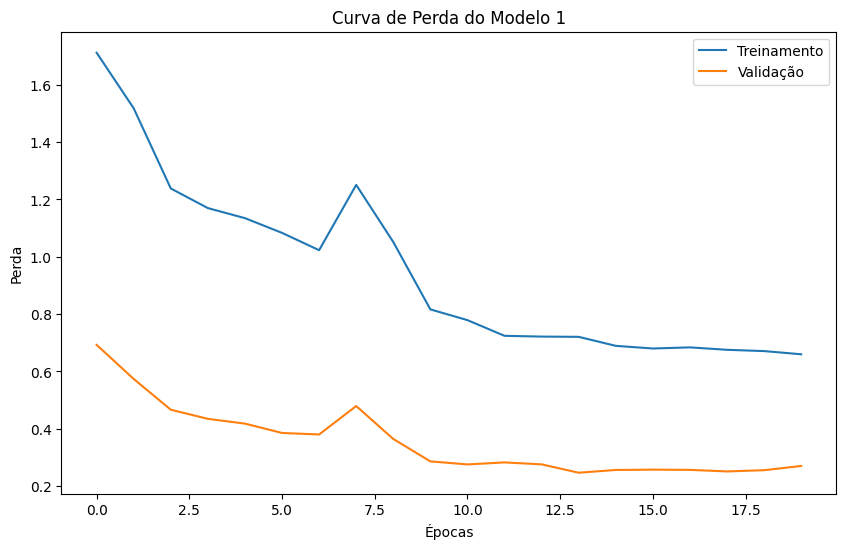

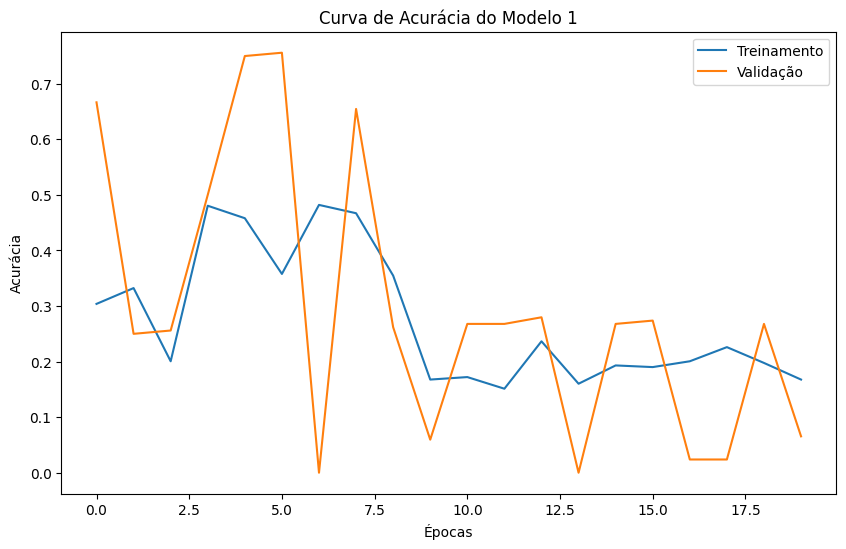

In [24]:
import matplotlib.pyplot as plt

pHistory = history3
# Plotando a curva de perda
plt.figure(figsize=(10, 6))
plt.plot(pHistory.history['loss'], label='Treinamento')
plt.plot(pHistory.history['val_loss'], label='Validação')
plt.title('Curva de Perda do Modelo 1')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

# Plotando a curva de acurácia
plt.figure(figsize=(10, 6))
plt.plot(pHistory.history['accuracy'], label='Treinamento')
plt.plot(pHistory.history['val_accuracy'], label='Validação')
plt.title('Curva de Acurácia do Modelo 1')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()


# Validação com texto real

In [25]:
import pandas as pd

# Textos reais para teste
textos_reais = [
    "se a menina chama rayane quando faz 15 anos automaticamente fica grávida",
    "Antes o homossexualismo era proibido.Depois passou a ser tolerado.Hoje é normal.Eu vou embora antes que vire obrigatório",
    "pode ser feia,pode ser gorda... só não pode ser feia é gorda.",
    "Nada contra negros mas EU PREFIRO aquele branquelo palmito cor de leite pra bejar na boca rsrs",
    "nada contra negros mas minha filha não vai trazer bandido pra casa não"
]

# Inicializando uma lista vazia para armazenar os resultados finais
resultados_finais = []

# Loop para percorrer cada texto real
for texto in textos_reais:
    # Tokenização e padronização
    sequencias_reais = tokenizer.texts_to_sequences([texto])
    sequencias_padded = pad_sequences(sequencias_reais, maxlen=max_sequence_length, padding='post', truncating='post')

    # Previsões
    predicao1 = model1.predict(sequencias_padded)
    predicao2 = model2.predict(sequencias_padded)
    predicao3 = model3.predict(sequencias_padded)

    # Inicializando uma lista vazia para armazenar os resultados deste texto
    resultados = []

    # Preenchendo a lista com as previsões
    for i, col in enumerate(correct_labels_columns):
        novo_registro = {
            'Texto': texto,
            'Etiqueta': col,
            'Modelo 1 (%)': round(predicao1[0][i] * 100, 2),
            'Modelo 2 (%)': round(predicao2[0][i] * 100, 2),
            'Modelo 3 (%)': round(predicao3[0][i] * 100, 2)
        }
        resultados.append(novo_registro)

    # Adicionando os resultados deste texto à lista final
    resultados_finais.extend(resultados)

# Transformando a lista de dicionários em um DataFrame
df_resultados_finais = pd.DataFrame(resultados_finais)

# Visualizando o DataFrame
df_resultados_finais


1/1 [==============================] - 0s 24ms/step


,Texto,Etiqueta,Modelo 1 (%),Modelo 2 (%),Modelo 3 (%)
0,se a menina chama rayane quando faz 15 anos au...,Sexism,13.47,11.18,40.74
1,se a menina chama rayane quando faz 15 anos au...,Women,12.57,10.38,36.80
2,se a menina chama rayane quando faz 15 anos au...,Homophobia,48.05,5.05,44.34
3,se a menina chama rayane quando faz 15 anos au...,Homossexuals,45.88,3.47,41.56
4,se a menina chama rayane quando faz 15 anos au...,Lesbians,40.88,1.18,38.76
5,se a menina chama rayane quando faz 15 anos au...,Body,1.51,0.32,16.16
6,se a menina chama rayane quando faz 15 anos au...,Fat.people,1.33,0.17,15.99
7,se a menina chama rayane quando faz 15 anos au...,Fat.women,0.99,0.11,9.44
8,se a menina chama rayane quando faz 15 anos au...,Ugly.people,0.45,0.00,8.00
9,se a menina chama rayane quando faz 15 anos au...,Ugly.women,0.62,0.00,9.00


# Matrix de confusão para os 3 modelos

7/7 [==============================] - 0s 6ms/step


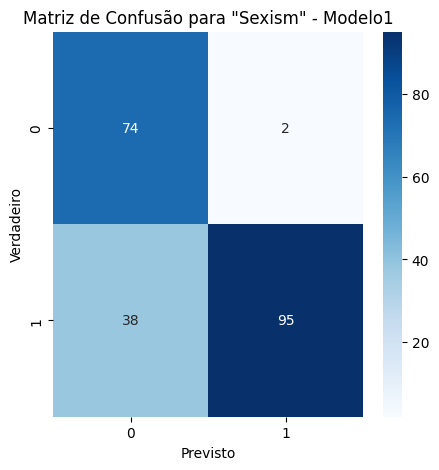

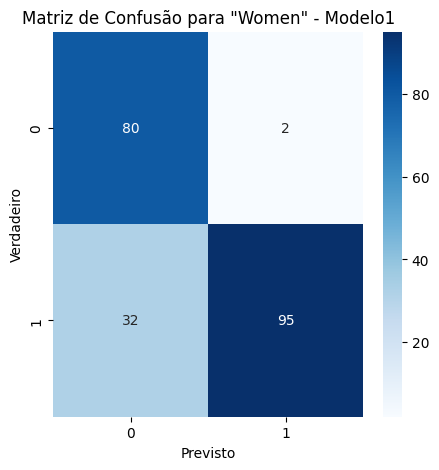

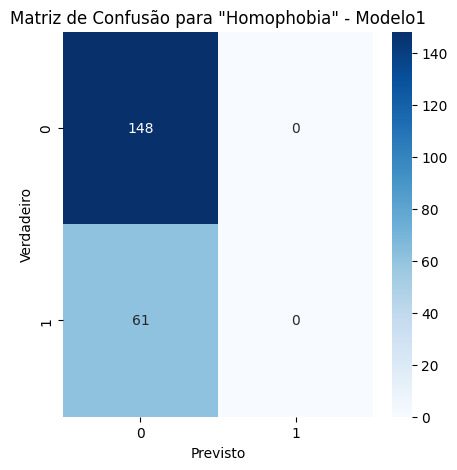

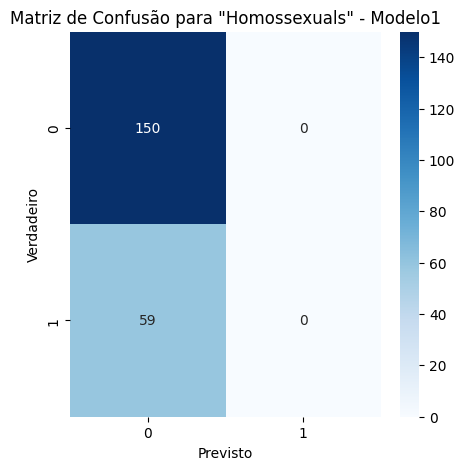

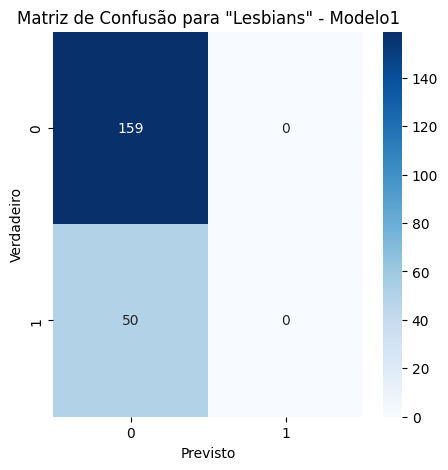

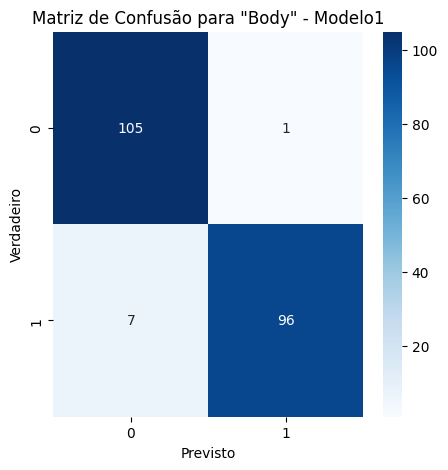

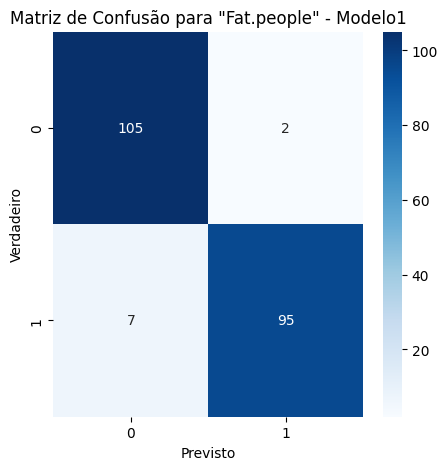

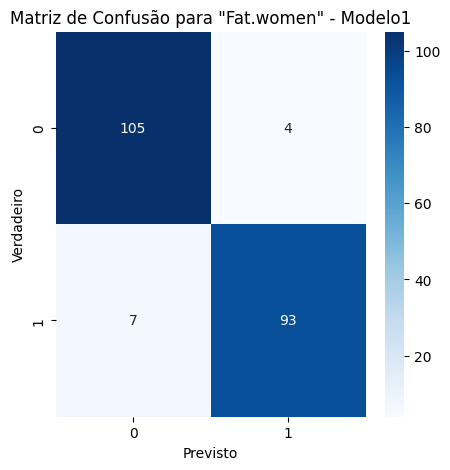

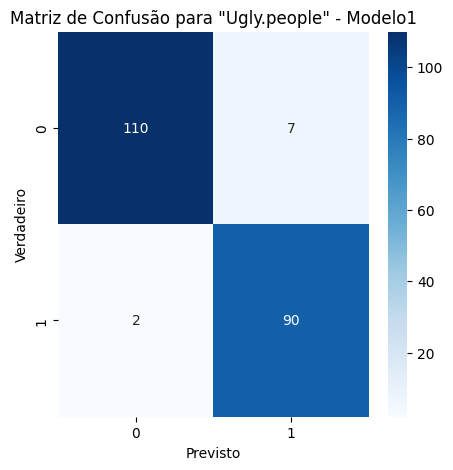

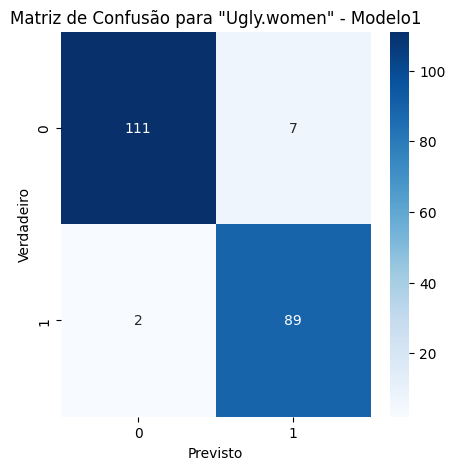

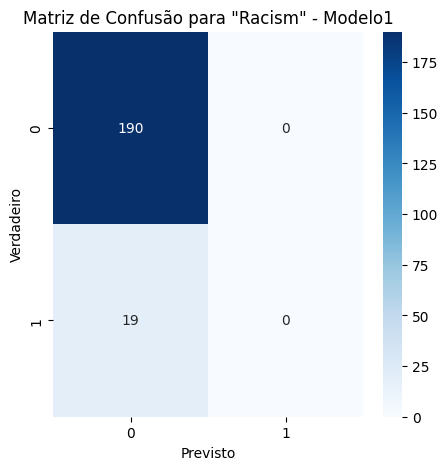

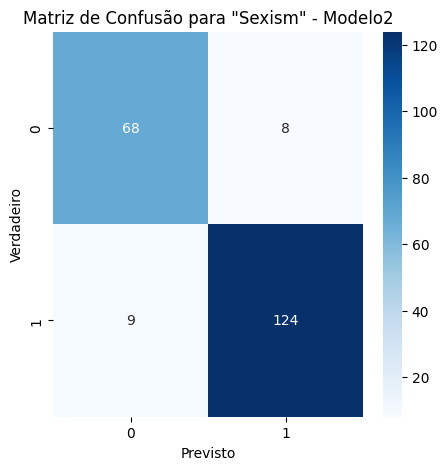

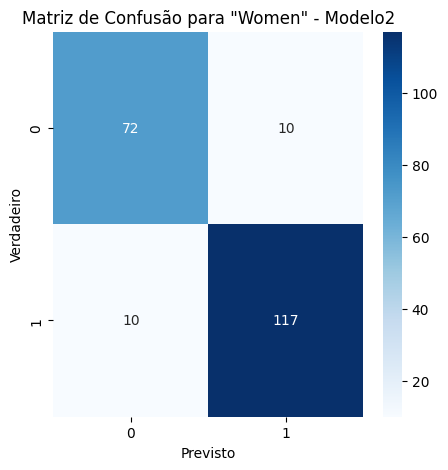

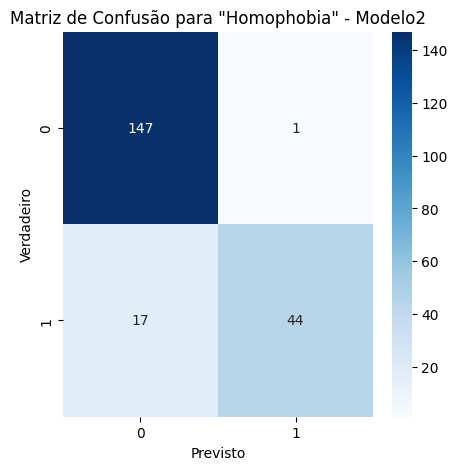

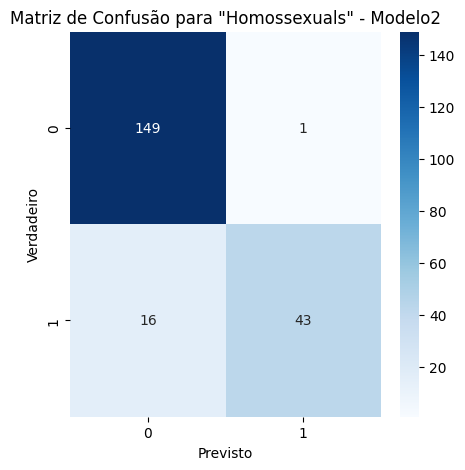

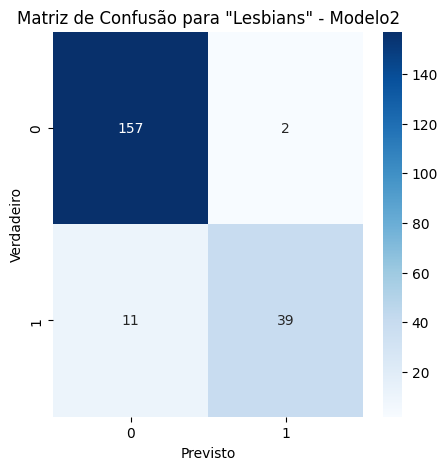

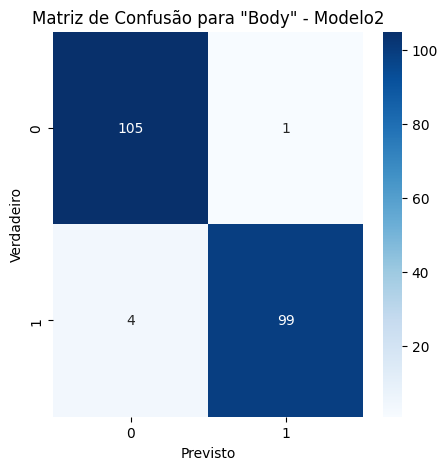

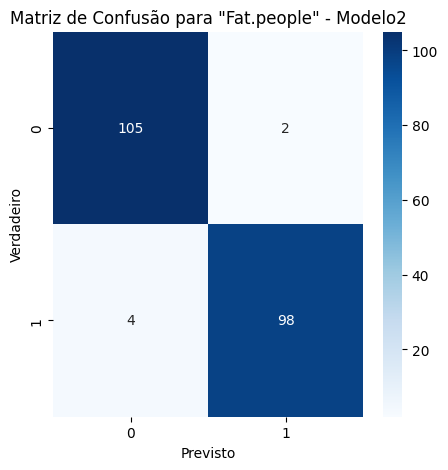

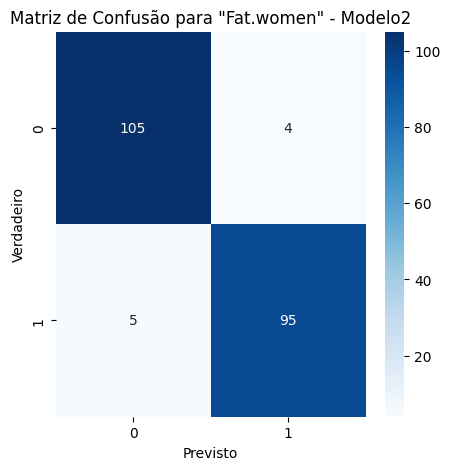

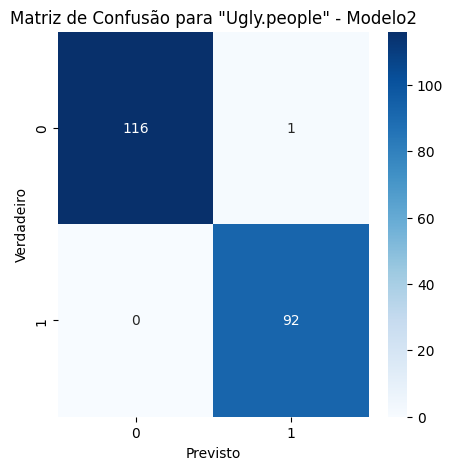

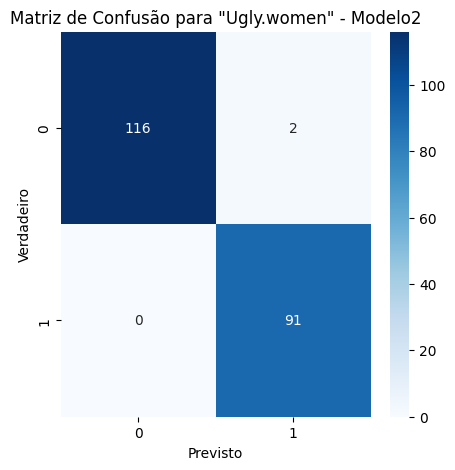

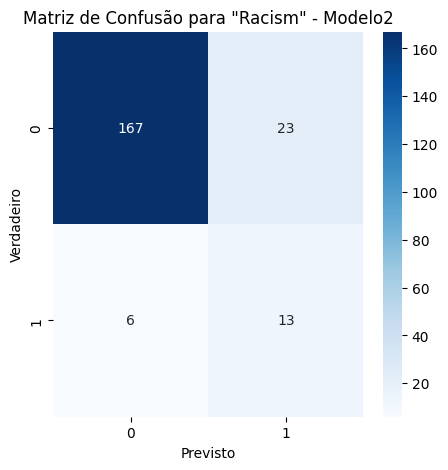

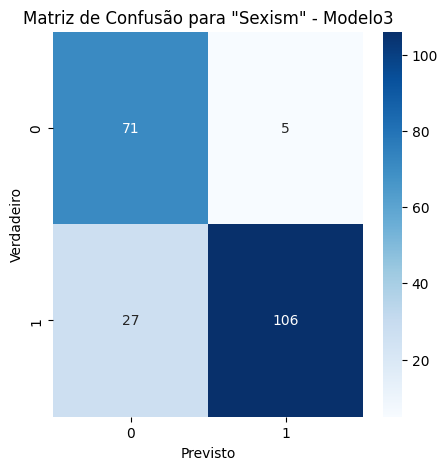

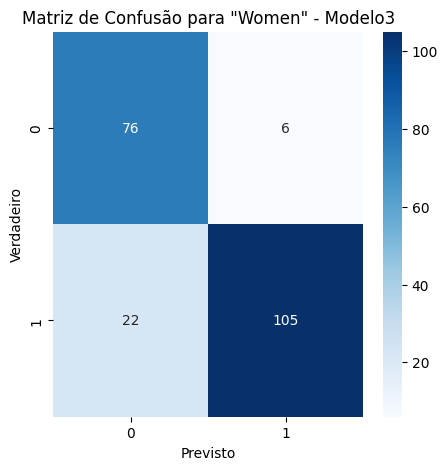

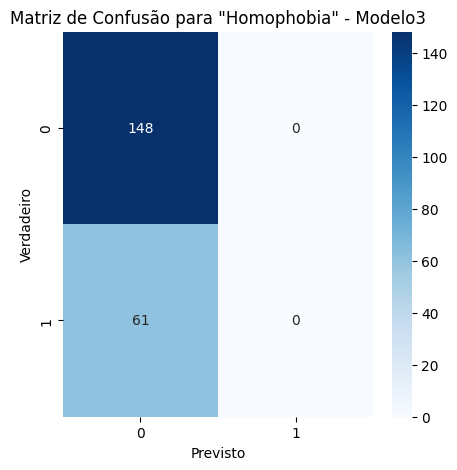

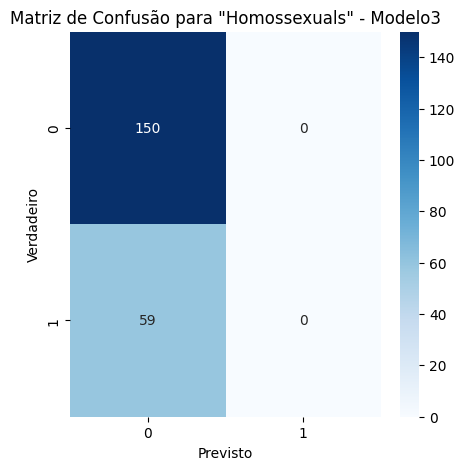

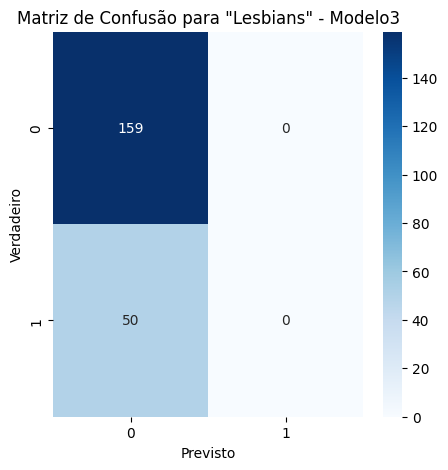

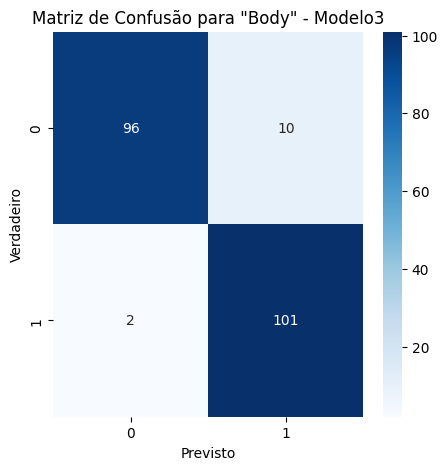

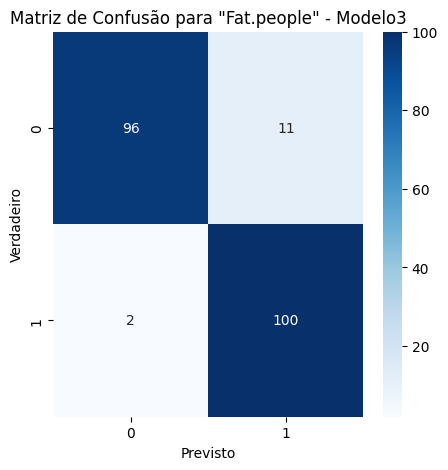

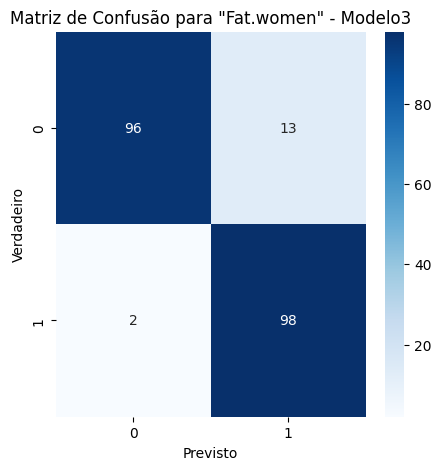

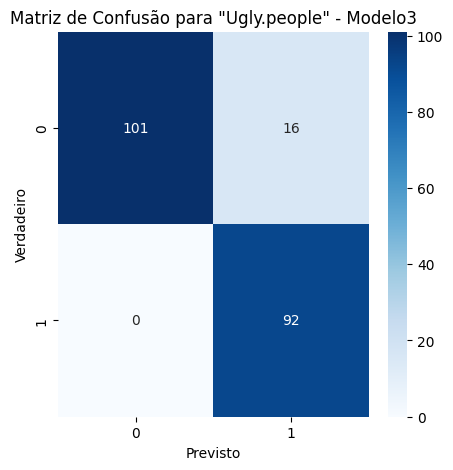

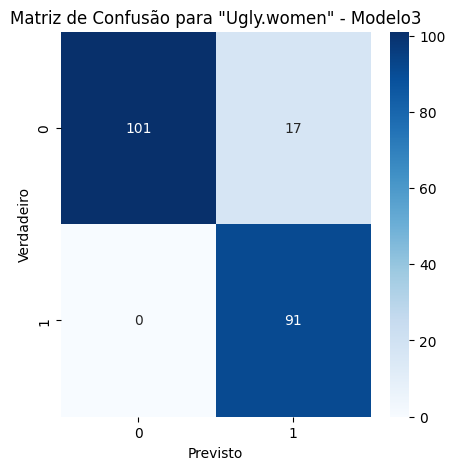

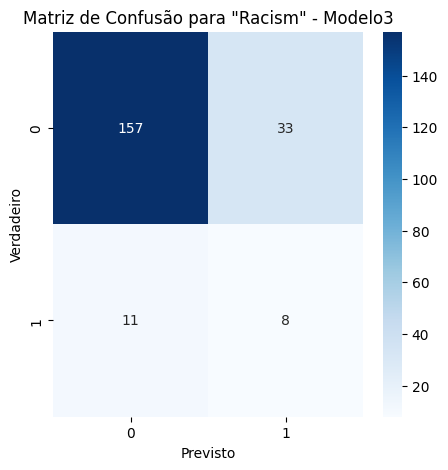

In [26]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrices(y_true, y_pred, label_names, model_name):
    cms = multilabel_confusion_matrix(y_true, y_pred)
    
    for i, (label, cm) in enumerate(zip(label_names, cms)):
        plt.figure(figsize=(5, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Matriz de Confusão para "{label}" - {model_name}')
        plt.xlabel('Previsto')
        plt.ylabel('Verdadeiro')
        plt.savefig(f'Confusion_Matrix_{model_name}_{label}.png')
        plt.show()

# Fazer previsões no conjunto de teste
y_pred1 = model1.predict(X_test) > 0.5
y_pred2 = model2.predict(X_test) > 0.5
y_pred3 = model3.predict(X_test) > 0.5

# Gerar as matrizes de confusão para todos os rótulos e modelos
plot_confusion_matrices(y_test, y_pred1, correct_labels_columns, 'Modelo1')
plot_confusion_matrices(y_test, y_pred2, correct_labels_columns, 'Modelo2')
plot_confusion_matrices(y_test, y_pred3, correct_labels_columns, 'Modelo3')


# 7. Deployment


### Salvar o Melhor Modelo e o Tokenizador

In [28]:
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint

# Lista para acompanhar as perdas de validação de cada modelo
val_losses = []

# Treinamento do Modelo 1
history1 = model1.fit(X_train, y_train, epochs=20, batch_size=8, validation_split=0.2, class_weight=class_weight_dict)
val_losses.append(min(history1.history['val_loss']))  # Salva a menor perda de validação

# Treinamento do Modelo 2
history2 = model2.fit(X_train, y_train, epochs=20, batch_size=8, validation_split=0.2, class_weight=class_weight_dict)
val_losses.append(min(history2.history['val_loss']))  # Salva a menor perda de validação

# Treinamento do Modelo 3
history3 = model3.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_split=0.2, class_weight=class_weight_dict)
val_losses.append(min(history3.history['val_loss']))  # Salva a menor perda de validação

# Identifica o modelo com a menor perda de validação
best_model_index = val_losses.index(min(val_losses))

# Salvar o modelo escolhido como o melhor
if best_model_index == 0:
    best_model = model1
elif best_model_index == 1:
    best_model = model2
else:
    best_model = model3

# Salvar o modelo escolhido como o melhor
best_model.save("best_hate_speech_model.h5")

# Salvar o tokenizador
with open('hate_speech_tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)



Epoch 1/20
84/84 [==============================] - 2s 28ms/step - loss: 0.7315 - accuracy: 0.7275 - val_loss: 0.2427 - val_accuracy: 0.7798
Epoch 2/20
84/84 [==============================] - 2s 28ms/step - loss: 0.7295 - accuracy: 0.7141 - val_loss: 0.2604 - val_accuracy: 0.7440
Epoch 3/20
84/84 [==============================] - 2s 29ms/step - loss: 0.7259 - accuracy: 0.6707 - val_loss: 0.3560 - val_accuracy: 0.8333
Epoch 4/20
84/84 [==============================] - 2s 28ms/step - loss: 0.7835 - accuracy: 0.8039 - val_loss: 0.3009 - val_accuracy: 0.8036
Epoch 5/20
84/84 [==============================] - 2s 28ms/step - loss: 0.7288 - accuracy: 0.7410 - val_loss: 0.3119 - val_accuracy: 0.8155
Epoch 6/20
84/84 [==============================] - 2s 28ms/step - loss: 0.7970 - accuracy: 0.5389 - val_loss: 0.2519 - val_accuracy: 0.2381
Epoch 7/20
84/84 [==============================] - 2s 27ms/step - loss: 0.6618 - accuracy: 0.2695 - val_loss: 0.2271 - val_accuracy: 0.2798
Epoch 8/20
84

### Deployment (Opcional)

#### Encapsulamento do Modelo

O modelo foi encapsulado utilizando a biblioteca Streamlit. A escolha pelo Streamlit foi feita devido à sua simplicidade de uso e à capacidade de criar uma interface interativa para a aplicação de análise de discurso de ódio.

Justificativa:

1.  **Facilidade de Uso**: O Streamlit é conhecido por sua facilidade de uso e configuração. Ele permite criar rapidamente uma interface de usuário sem a necessidade de conhecimentos avançados em desenvolvimento web.
    
2.  **Interação com o Modelo**: Com o Streamlit, podemos criar uma interface amigável que permite aos usuários inserir texto para análise e receber resultados imediatos. Isso facilita a interação com o modelo de análise de discurso de ódio.
    
3.  **Visualização dos Resultados**: O Streamlit permite a fácil criação de gráficos e tabelas para visualização dos resultados. Neste projeto, utilizamos duas colunas para apresentar um resumo do modelo à esquerda e uma tabela de resultados à direita, facilitando a compreensão dos resultados.
    
4.  **Compartilhamento Fácil**: O Streamlit gera um aplicativo web que pode ser compartilhado com outros usuários de forma simples. No entanto, devido a limitações no plano gratuito de hospedagem, a aplicação não está atualmente disponível online.
    

Caso queira reproduzir a aplicação localmente, o código-fonte completo está disponível no meu [repositório GitHub](https://github.com/MarceloFullStack/detectar_discurso_de_odio_textos). Você pode seguir as instruções no README para configurar e executar a aplicação em seu ambiente local.


![Alt text](image.png)

![Alt text](image-1.png)

![Alt text](image-2.png)